# Answering Business Questions Using SQL

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Create Helper Functions

In [2]:
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql_query(q, conn)
    
def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)
        
def show_tables():
    q = '''
        SELECT 
            name,
            type
        FROM sqlite_master
        WHERE type IN ("table","view");
        
        '''
    return run_query(q)
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## Selecting New Albums to Purchase

In [3]:
q = '''
    WITH usa_tracks_sold AS
        (
         SELECT il.* FROM invoice_line il
         INNER JOIN invoice i ON il.invoice_id = i.invoice_id
         INNER JOIN customer c ON c.customer_id = i.customer_id
         WHERE c.country = 'USA'
         )
    SELECT g.name genre,
           COUNT(uts.invoice_line_id) tracks_sold,
           CAST(COUNT(uts.invoice_line_id) AS FLOAT) / (SELECT COUNT(*) FROM usa_tracks_sold) percentage
    FROM usa_tracks_sold uts
    INNER JOIN track t ON uts.track_id = t.track_id
    INNER JOIN genre g ON t.genre_id = g.genre_id
    GROUP BY 1
    ORDER BY 2 DESC
    LIMIT 10;
    
    '''
genre_sales_us = run_query(q)
genre_sales_us

,genre,tracks_sold,percentage
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


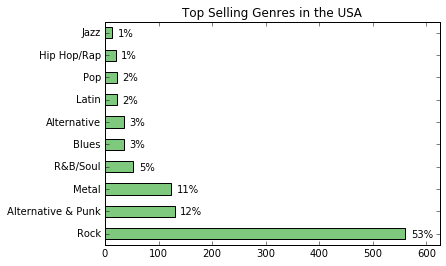

In [4]:
genre_sales_us.set_index("genre", drop=True, inplace=True)
genre_sales_us["tracks_sold"].plot.barh(
    title = "Top Selling Genres in the USA",
    xlim = (0,625),
    colormap=plt.cm.Accent
)
plt.ylabel('')

for i,label in enumerate(list(genre_sales_us.index)):
    score = genre_sales_us.loc[label, "tracks_sold"]
    label = (genre_sales_us.loc[label, "percentage"] * 100).astype(int).astype(str) + "%"
    plt.annotate(str(label), (score+10, i-0.15))
plt.show()

Based on sales of tracks across different genres in the USA, we should purchase the new albums by the following artists:

    Red Tone (Punk)
    Slim Jim Bites (Blues)
    Meteor and the Girls (Pop)
It's worth keeping in mind that combined, these three genres only make up only 17% of total sales, so we should be on the lookout for artists and albums from the 'rock' genre, which accounts for 53% of sales.

## Analyzing Employee Sales Performance

In [5]:
q = '''
    WITH customer_sales AS 
        (
        SELECT i.customer_id, 
               SUM(i.total) total_sales,
               c.support_rep_id 
            FROM invoice i 
        INNER JOIN customer c ON c.customer_id = i.customer_id
        GROUP BY 1,3
        )
    SELECT 
           e.first_name || " " || e.last_name employee,
           e.hire_date,
           SUM(cs.total_sales) total_sales
        FROM customer_sales cs 
        INNER JOIN employee e ON cs.support_rep_id = e.employee_id
        GROUP BY 1
    '''
run_query(q)

,employee,hire_date,total_sales
0,Jane Peacock,2017-04-01 00:00:00,1731.51
1,Margaret Park,2017-05-03 00:00:00,1584.00
2,Steve Johnson,2017-10-17 00:00:00,1393.92


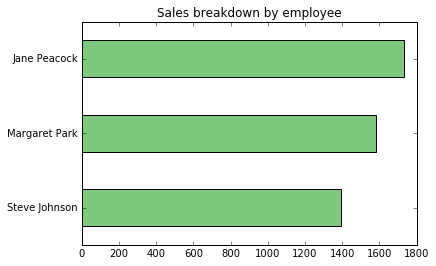

In [6]:
sales_rep_sales = run_query(q)
sales_rep_sales.set_index("employee", drop=True, inplace=True)
sales_rep_sales.sort_values("total_sales", inplace=True)
sales_rep_sales.plot.barh(
    legend=False,
    title="Sales breakdown by employee",
    colormap=plt.cm.Accent)
plt.ylabel('')
plt.show()

While there is a 20% difference in sales between Jane and Margaret, the difference roughly corresponds with the differences in their hiring dates.

## Analyzing Sales by Country

In [7]:
sales_by_country = '''
WITH country_or_other AS
    (
    SELECT 
        CASE WHEN (
                SELECT COUNT(*) FROM customer
                WHERE country = c.country
            )=1 THEN "OTHER" 
            ELSE c.country END AS country,
        il.*,
        c.customer_id 
    FROM invoice_line il
    INNER JOIN invoice i ON il.invoice_id = i.invoice_id
    INNER JOIN customer c ON c.customer_id = i.customer_id
    )

SELECT 
     country,
     customers,
     total_sales,
     customer_lifetime_value,
     average_order
     
    FROM 
        (
         SELECT 
             country,
             COUNT(distinct customer_id) customers,
             SUM(unit_price) total_sales,
             SUM(unit_price) / COUNT(distinct customer_id) customer_lifetime_value,
             SUM(unit_price) / COUNT(distinct invoice_id) average_order,
             CASE WHEN country = "OTHER" THEN 1 ELSE 0 END AS sort
          FROM country_or_other
          GROUP BY country
          ORDER BY sort ASC, total_sales DESC
           );
      '''
run_query(sales_by_country)    

,country,customers,total_sales,customer_lifetime_value,average_order
0,USA,13,1040.49,80.037692,7.942672
1,Canada,8,535.59,66.948750,7.047237
2,Brazil,5,427.68,85.536000,7.011148
3,France,5,389.07,77.814000,7.781400
4,Germany,4,334.62,83.655000,8.161463
5,Czech Republic,2,273.24,136.620000,9.108000
6,United Kingdom,3,245.52,81.840000,8.768571
7,Portugal,2,185.13,92.565000,6.383793
8,India,2,183.15,91.575000,8.721429
9,OTHER,15,1094.94,72.996000,7.448571


## Visualizing Sales by Country

                customers  total_sales
                                      
USA             22.033898    22.093757
Canada          13.559322    11.372714
Brazil           8.474576     9.081354
France           8.474576     8.261509
Germany          6.779661     7.105318
Czech Republic   3.389831     5.801976
United Kingdom   5.084746     5.213370
Portugal         3.389831     3.931049
India            3.389831     3.889006
OTHER           25.423729    23.249947


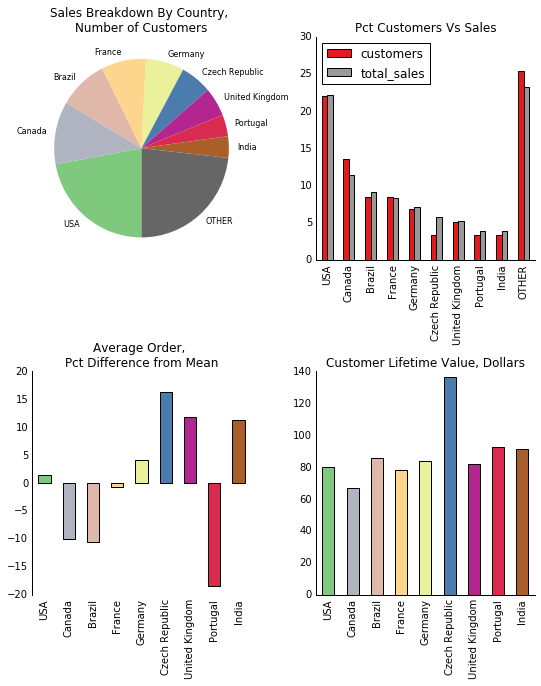

In [8]:
country_metrics = run_query(sales_by_country)
country_metrics.set_index("country", drop=True, inplace=True)
#print(country_metrics.head())
colors = [plt.cm.Accent(i) for i in np.linspace(0, 1, country_metrics.shape[0])]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 10))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=.5, wspace=.3)

#top left
sales_breakdown = country_metrics['total_sales'].copy().rename('')
sales_breakdown.plot.pie(
                    ax=ax1,
                    startangle=-90,
                    counterclock=False,
                    title="Sales Breakdown By Country, \nNumber of Customers",
                    colormap=plt.cm.Accent,
                    fontsize=8,
                    wedgeprops={'linewidth':0}
            )
            
            
# top right
cvd_cols = ["customers", "total_sales"]
custs_vs_dollars = country_metrics[cvd_cols].copy()
custs_vs_dollars.index.name = ''
for c in cvd_cols:
    custs_vs_dollars[c] /= custs_vs_dollars[c].sum() / 100
print(custs_vs_dollars)
custs_vs_dollars.plot.bar(
    ax=ax2,
    colormap=plt.cm.Set1,
    title='Pct Customers Vs Sales')
ax2.tick_params(top="off", right="off", left="off", bottom="off")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
    
# bottom left
avg_order = country_metrics['average_order'].copy()
avg_order.index.name = ''
difference_from_avg = avg_order * 100 / avg_order.mean() - 100
difference_from_avg.drop("OTHER", inplace=True)
difference_from_avg.plot.bar(
    ax=ax3,
    color=colors,
    title="Average Order, \nPct Difference from Mean")
ax3.tick_params(top="off", right="off", left="off", bottom="off")
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["bottom"].set_visible(False)

# bottom right
ltv = country_metrics['customer_lifetime_value'].copy()
ltv.index.name = ''
ltv.drop('OTHER', inplace=True)
ltv.plot.bar(
    ax=ax4,
    color=colors,
    title="Customer Lifetime Value, Dollars")

ax4.tick_params(top="off", right="off", left="off", bottom="off")
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)

plt.show()



Based on the data, there may be opportunity in the following countries:

    Czech Republic
    United Kingdom
    India

It's worth keeping in mind that because the amount of data from each of these countries is relatively low. Because of this, we should be cautious spending too much money on new marketing campaigns, as the sample size is not large enough to give us high confidence. A better approach would be to run small campaigns in these countries, collecting and analyzing the new customers to make sure that these trends hold with new customers.


## Analyzing Album Vs Individual Track Purchases

In [38]:
albums_vs_tracks = '''
WITH invoice_first_track AS 
    (
    select 
        il.invoice_id invoice_id,
        min(il.track_id) first_track_id  
    from invoice_line il
    group by 1 )
    
SELECT 
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / (SELECT COUNT(*) FROM invoice) percent
    
FROM 
    (
    SELECT ifs.*,
    CASE 
        WHEN (
        
        SELECT t.track_id from track t
        where t.album_id = (
                            SELECT t2.album_id from track t2
                            WHERE t2.track_id = ifs.first_track_id
                           )
        EXCEPT
        
        SELECT il2.track_id from invoice_line il2
        WHERE il2.invoice_id = ifs.invoice_id
        ) IS NULL
    AND
    (
        SELECT il2.track_id from invoice_line il2
        WHERE il2.invoice_id = ifs.invoice_id
        
        EXCEPT
        
        SELECT t.track_id from track t
        where t.album_id = (
                            SELECT t2.album_id from track t2
                            WHERE t2.track_id = ifs.first_track_id
                            )
                            
    ) IS NULL 
    THEN "yes"
    ELSE "no" 
    END AS "album_purchase"
    FROM invoice_first_track ifs
    )
GROUP BY album_purchase;
    '''
run_query(albums_vs_tracks)

,album_purchase,number_of_invoices,percent
0,no,500,0.814332
1,yes,114,0.185668
